# CartPole-v1 Deep Q-Learning

## Requirements

In [1]:
from utils import *

install_requirements_RL();

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # Error only

import tensorflow as tf
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import io
import base64
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from IPython import display as ipythondisplay

import random
import datetime

from collections import deque

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start();

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('gym-results/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 200px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './gym-results', force=True)
    return env

## Random Agent

In [5]:
env = wrap_env(gym.make("CartPole-v1"))
print(env.action_space)

Discrete(2)


In [6]:
observation = env.reset()

while True:
    env.render()
    
    # Random Agent here
    action = env.action_space.sample()   
         
    observation, reward, done, info = env.step(action) 
   
    if done: 
        break;
            
env.close()
show_video()

## DQN Agent

In [8]:
ENV_NAME = "CartPole-v1"

# Cummulative discounted reward and optimizer learning rate
GAMMA = 0.9
LEARNING_RATE = 0.001

# Number maximum of actions kept for later analysis (replay is sampled from this structure)
# When replay is performed BATCH_SIZE sets the number of examples to use
MEMORY_SIZE = 1000000
BATCH_SIZE = 20

# Exploration strategy
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.999

class DQNSolver:

    def __init__(self, observation_space, action_space):
        """
        Initial settings and model definition
        """
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        """
        Store an action to the memory array
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose between explotation and exploration
        """
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        return self.act_best(state)
    
    def act_best(self, state):
        """
        Explotation. Use the best known action
        """
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        """
        Replays actions to fit the network
        """
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Randomly sample from all the actions
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            
            # If it is not a terminal state, update the Q-value associated with this action
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            
            # Fit the function with this example
            self.model.fit(state, q_values, verbose=0)
            
        # Update the exploration rate 
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

### Train the agent

In [10]:
DEVICE_TYPE = 'gpu' # 'cpu'
DEVICE = 1

# Max runs
LAST = 1000

# An epoch is considered a success if this score is reached
EPOCH_SUCESS = 200

# This number limits the number of steps per epoch (to avoid very long or perfect executions)
MAX_REACHED = 500

# If the EPOCH_SUCESS value is reached consecutively, training stops
CONSECUTIVE_WINS = 2

# Print a summary in some epochs
EPOCH_VERBOSE = 1

# The best weights are updated in the following path
model_save_path = './models/myDQN'

best_score = 0
scores = np.array([])

try:
    with tf.device(f'/device:{DEVICE_TYPE}:{DEVICE}'):
        
        # Create a gym environment and a DQNSolver object
        env = gym.make(ENV_NAME)
        observation_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        dqn_solver = DQNSolver(observation_space, action_space)

        # Train for a set amount of time
        for run in trange(1,LAST+1):
            state = env.reset()
            state = np.reshape(state, [1, observation_space])

            # While MAX_REACHED is to reached
            for step_score in range(MAX_REACHED+1):
                
                # Choose an action (explotation vs exploration) and retrieve the new state
                action = dqn_solver.act(state)
                state_next, reward, terminal, info = env.step(action)
                
                # Obtain a reward (1 if alive, -1 if dead)
                reward = reward if not terminal else -reward
                
                # Remember this action (this does not fit the network yet)
                state_next = np.reshape(state_next, [1, observation_space])
                dqn_solver.remember(state, action, reward, state_next, terminal)
                state = state_next
                
                # If this epoch has ended, stop
                if terminal or step_score >= MAX_REACHED:  
                    
                    # If we have obtained a higer value, save the model
                    if step_score > best_score:
                        dqn_solver.model.save(model_save_path)
                        best_score = step_score
                        
                    scores = np.append(scores, step_score)
                    break
                    
                # Fit the network by selecting previous actions and learning from them
                dqn_solver.experience_replay()
            
            # To keep track in the output
            if run % EPOCH_VERBOSE == 0:
                print ("Run: {:04d}  Exploration: {:6.5f}  Score: {:d}".format(run, dqn_solver.exploration_rate, step_score))
            
            # If a number of consecutive wins is achieved, stop the training process
            if len(scores)>=CONSECUTIVE_WINS:
                if (scores[-CONSECUTIVE_WINS:]>=EPOCH_SUCESS).all():
                    raise KeyboardInterrupt
                    
except KeyboardInterrupt:
    pass

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/myDQN/assets
Run: 1, exploration: 0.9655885070369844, score: 54
INFO:tensorflow:Assets written to: ./models/myDQN/assets
Run: 2, exploration: 0.9129761418240965, score: 56
Run: 3, exploration: 0.8895331192339416, score: 26
Run: 4, exploration: 0.8833250364922639, score: 7
Run: 5, exploration: 0.8666920568517111, score: 19
Run: 6, exploration: 0.8368678892362568, score: 35
Run: 7, exploration: 0.8268805241487632, score: 12
Run: 8, exploration: 0.8137491998735046, score: 16
Run: 9, exploration: 0.8024304668606914, score: 14
Run: 10, exploration: 0.7928540855310416, score: 12
Run: 11, exploration: 0.7686407469632577, score: 31
Run: 12, exploration: 0.7451668707698216, score: 31
Run: 13, exploration: 0.7311354045730207, score: 19
Run: 14, exploration: 0.7102266645246085, score: 29
Run: 15, exploration: 0.685786704656174, score: 35
Run: 16, exploration: 0.676247848439

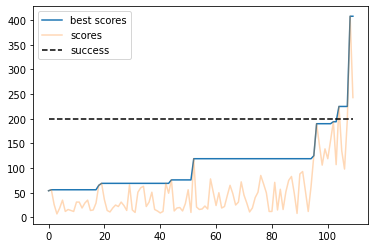

In [38]:
plt.plot(pd.Series(scores).cummax().values, label='best scores')
plt.plot(scores, alpha=0.3, label='scores')
plt.plot([EPOCH_SUCESS]*len(scores), c='k',linestyle='dashed', label='success')
plt.legend()
plt.show()

### Reload model and weights from saved file

In [ ]:
model_load_path = './models/myDQN'

In [11]:
from tensorflow.keras.models import load_model

env = wrap_env(gym.make("CartPole-v1"))

observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Load existing solver
dqn_solver = DQNSolver(observation_space, action_space)
dqn_solver.model = load_model(model_load_path)

### Visualize the result

In [15]:
observation = env.reset()

step = 0
while True:
    env.render()

    observation = np.reshape(observation, [1, env.observation_space.shape[0]])
    action = dqn_solver.act_best(observation)
    step+=1
    observation, reward, done, info = env.step(action) 

    if done: 
        break;

print(f'{step} steps')
env.close()
show_video()

336 steps
